# **Spotify Project**

## **Hypothesis:** I hypothesize one can predict a song's genre by using it's audio features. 
### Below is the link to the dataset on kaggle: https://www.kaggle.com/datasets/solomonameh/spotify-music-dataset/data?select=high_popularity_spotify_data.csv
### Project go-round 1:

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk

In [56]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Understanding the data

In [57]:
#high_popularity_spotify_data = high spotify = hs
hs = pd.read_csv('D:\Datasets\high_popularity_spotify_data.csv')
hs.head()

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,track_popularity,track_album_name,playlist_name,track_name,track_album_release_date,instrumentalness,mode,key,duration_ms,acousticness,playlist_subgenre
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3,0.0304,100,Die With A Smile,Today's Top Hits,Die With A Smile,8/16/2024,0.0000,0,6,251668,0.3080,mainstream
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4,0.0358,97,HIT ME HARD AND SOFT,Today's Top Hits,BIRDS OF A FEATHER,5/17/2024,0.0608,1,2,210373,0.2000,mainstream
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4,0.0368,93,The Secret of Us (Deluxe),Today's Top Hits,That’s So True,10/18/2024,0.0000,1,1,166300,0.2140,mainstream
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4,0.0634,81,Short n' Sweet,Today's Top Hits,Taste,8/23/2024,0.0000,0,0,157280,0.0939,mainstream
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4,0.2600,98,APT.,Today's Top Hits,APT.,10/18/2024,0.0000,0,0,169917,0.0283,mainstream


In [58]:
# I want to understand the data types of the columns and the number of NaN values in each column
hs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   energy                    1686 non-null   float64
 1   tempo                     1686 non-null   float64
 2   danceability              1686 non-null   float64
 3   playlist_genre            1686 non-null   object 
 4   loudness                  1686 non-null   float64
 5   liveness                  1686 non-null   float64
 6   valence                   1686 non-null   float64
 7   track_artist              1686 non-null   object 
 8   time_signature            1686 non-null   int64  
 9   speechiness               1686 non-null   float64
 10  track_popularity          1686 non-null   int64  
 11  track_album_name          1685 non-null   object 
 12  playlist_name             1686 non-null   object 
 13  track_name                1686 non-null   object 
 14  track_al

In [59]:
#Does the dataset have any missing values? and where to find them
has_na = hs.isna().any().any()
print(has_na)

True


In [60]:
na_columns = hs.isna().sum()
na_columns = na_columns[na_columns > 0]
print(na_columns)
#All good I'm gonna let it slide, on the other hand I did delete 8 columns that were not applicable to the analysis such as the url, and api columns in excel as csv file.

track_album_name    1
dtype: int64


In [61]:
#Make sure there are no track_names that are repeated
hs['track_name'].value_counts()
#Delete the rows with the repeated track names
hs = hs.drop_duplicates(subset='track_name', keep='first')

In [62]:
hs['playlist_genre'].value_counts()
# The dataset has an off balance of the genres, which will off course any predictions as the model will have more data of a genre(pop) to interpret and overlay onto another genre by accident. 
# To fix this problem I will need to either take away data from the larger genre's(CAUTION: could be throwing away useful information), add more data to the smaller genre's or create weights to balance the data.


playlist_genre
pop           287
rock          203
hip-hop       200
latin         162
electronic    125
gaming         74
ambient        50
r&b            50
punk           46
blues          37
folk           28
arabic         27
metal          18
afrobeats      15
brazilian      13
j-pop          11
k-pop          11
classical      10
indian          9
korean          7
turkish         7
reggae          4
world           4
country         3
indie           3
lofi            2
soul            1
jazz            1
Name: count, dtype: int64

### Data Preparation

In [63]:
hs_required = hs[['energy', 'tempo', 'danceability','playlist_genre', 'loudness',
       'liveness', 'valence','time_signature', 'speechiness',
       'track_popularity','instrumentalness', 'mode', 'key',
       'duration_ms', 'acousticness']]
hs_required.head()

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,time_signature,speechiness,track_popularity,instrumentalness,mode,key,duration_ms,acousticness
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,3,0.0304,100,0.0000,0,6,251668,0.3080
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,4,0.0358,97,0.0608,1,2,210373,0.2000
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,4,0.0368,93,0.0000,1,1,166300,0.2140
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,4,0.0634,81,0.0000,0,0,157280,0.0939
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,4,0.2600,98,0.0000,0,0,169917,0.0283


In [64]:
#Ran into error "could not convert string to float: 'hip-hop'"
hs_required['playlist_genre'].astype(object)
#Going to take out the dash between the playlist_genre for the genre hip-hop
#Realizing I need to encode the output column since it's an object data type

0         pop
1         pop
2         pop
3         pop
4         pop
        ...  
1680    latin
1681    latin
1682    latin
1683    latin
1685      pop
Name: playlist_genre, Length: 1408, dtype: object

In [65]:
hs_required['playlist_genre'].unique()

array(['pop', 'rock', 'jazz', 'classical', 'hip-hop', 'afrobeats',
       'latin', 'indian', 'country', 'r&b', 'electronic', 'soul',
       'gaming', 'j-pop', 'metal', 'reggae', 'k-pop', 'arabic', 'punk',
       'blues', 'folk', 'lofi', 'brazilian', 'turkish', 'ambient',
       'korean', 'world', 'indie'], dtype=object)

In [66]:
hs_new = hs_required

In [67]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
hs_required['playlist_genre'] = label_encoder.fit_transform(hs_required['playlist_genre'])

#One-hot encode the 'playlist_genre' column
#hs_encoded = pd.get_dummies(hs_required, columns=['playlist_genre'])

print(hs_required.head())

   energy    tempo  danceability  playlist_genre  loudness  liveness  valence  \
0   0.592  157.969         0.521              20    -7.777     0.122    0.535   
1   0.507  104.978         0.747              20   -10.171     0.117    0.438   
2   0.808  108.548         0.554              20    -4.169     0.159    0.372   
3   0.910  112.966         0.670              20    -4.070     0.304    0.786   
4   0.783  149.027         0.777              20    -4.477     0.355    0.939   

   time_signature  speechiness  track_popularity  instrumentalness  mode  key  \
0               3       0.0304               100            0.0000     0    6   
1               4       0.0358                97            0.0608     1    2   
2               4       0.0368                93            0.0000     1    1   
3               4       0.0634                81            0.0000     0    0   
4               4       0.2600                98            0.0000     0    0   

   duration_ms  acousticne

C:\Users\tbear\AppData\Local\Temp\ipykernel_32520\3233974949.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hs_required['playlist_genre'] = label_encoder.fit_transform(hs_required['playlist_genre'])


In [68]:
#Visual table of the encoded values
encoded_values = pd.DataFrame({
    'Encoded Value': range(len(label_encoder.classes_)),
    'Actual Value': label_encoder.classes_
})
print(encoded_values)

    Encoded Value Actual Value
0               0    afrobeats
1               1      ambient
2               2       arabic
3               3        blues
4               4    brazilian
5               5    classical
6               6      country
7               7   electronic
8               8         folk
9               9       gaming
10             10      hip-hop
11             11       indian
12             12        indie
13             13        j-pop
14             14         jazz
15             15        k-pop
16             16       korean
17             17        latin
18             18         lofi
19             19        metal
20             20          pop
21             21         punk
22             22          r&b
23             23       reggae
24             24         rock
25             25         soul
26             26      turkish
27             27        world


## Data Preparation

### Data Splitting

In [69]:
y = hs_required['playlist_genre']
X = hs_required.drop('playlist_genre', axis=1)

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)


In [71]:
y_test.head()

370     22
1018    20
1389    17
198     10
911     20
Name: playlist_genre, dtype: int64

## Model Building

### Linear Regression

#### Training the Model

In [72]:
from sklearn.linear_model import LinearRegression
# Fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

#### Applying the model to make predictions

In [73]:
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)


In [74]:
print(y_lr_train_pred)

[ 7.53002504 19.2809347  16.2972224  ... 12.16002903 16.48363017
 13.19334811]


#### Evaluate Model Performance (Linear Regression )

In [75]:
y_train

1595    10
640     24
1364    17
48      24
158     10
        ..
1316    17
1356    17
1544    10
1012    20
1352    17
Name: playlist_genre, Length: 1126, dtype: int64

In [76]:
y_lr_train_pred

array([ 7.53002504, 19.2809347 , 16.2972224 , ..., 12.16002903,
       16.48363017, 13.19334811], shape=(1126,))

In [77]:
# Calculate the mean square error (mse) and r2 score
from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)

lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)

print(f"Train MSE: {lr_train_mse}, Train R2: {lr_train_r2}")
print(f"Test MSE: {lr_test_mse}, Test R2: {lr_test_r2}")

Train MSE: 38.385695077113404, Train R2: 0.26191383048121053
Test MSE: 40.868998253433496, Test R2: 0.23109879017490953


In [78]:
#lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
#lr_train_r2 = r2_score(y_train, y_lr_train_pred)

#lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
#lr_test_r2 = r2_score(y_test, y_lr_test_pred)

#print(f"Train MSE: {lr_train_mse}, Train R2: {lr_train_r2}")
#print(f"Test MSE: {lr_test_mse}, Test R2: {lr_test_r2}")


In [79]:
lr_results = pd.DataFrame(['Linear Regression', lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2]).transpose()
lr_results.columns = ['Method', 'Train MSE', 'Train R2', 'Test MSE', 'Test R2']

### Random Forest

#### Training RF Regressor

In [80]:
from sklearn.ensemble import RandomForestRegressor
#So apparently if the output value is a categorical value you use a classification model,
# but if it's a quantitative value you use a regression model

In [81]:
rf = RandomForestRegressor(max_depth=2, random_state=100)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=100)

##### RF Regressor Predictions

In [82]:
y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

###### **RF Regressor Evaluation**

In [83]:
# Calculate the mean square error (mse) and r2 score
from sklearn.metrics import mean_squared_error, r2_score

rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

print(f"Train MSE: {rf_train_mse}, Train R2: {rf_train_r2}")
print(f"Test MSE: {rf_test_mse}, Test R2: {rf_test_r2}")

Train MSE: 41.96026295781403, Train R2: 0.19318147824814447
Test MSE: 46.596898331487225, Test R2: 0.12333521661086366


In [84]:
rf_results = pd.DataFrame(['Random Forest Regressor', rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Train MSE', 'Train R2', 'Test MSE', 'Test R2']

#### Training RF Classifier

In [85]:
from sklearn.ensemble import RandomForestClassifier

In [86]:
rfc = RandomForestClassifier(max_depth=2, random_state=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=100)

##### RF Classifier makes predictions

In [87]:
y_rfc_train_pred = rfc.predict(X_train)
y_rfc_test_pred = rfc.predict(X_test)

###### **RF Classifier Evaluation** ######

In [88]:
# Calculate the mean square error (mse) and r2 score
from sklearn.metrics import mean_squared_error, r2_score

rfc_train_mse = mean_squared_error(y_train, y_rfc_train_pred)
rfc_train_r2 = r2_score(y_train, y_rfc_train_pred)

rfc_test_mse = mean_squared_error(y_test, y_rfc_test_pred)
rfc_test_r2 = r2_score(y_test, y_rfc_test_pred)

print(f"Train MSE: {rfc_train_mse}, Train R2: {rfc_train_r2}")
print(f"Test MSE: {rfc_test_mse}, Test R2: {rfc_test_r2}")

Train MSE: 64.57637655417406, Train R2: -0.24168470354705773
Test MSE: 64.75531914893617, Test R2: -0.21829370339518572


In [89]:
rfc_results = pd.DataFrame(['Random Forest Classifier', rfc_train_mse, rfc_train_r2, rfc_test_mse, rfc_test_r2]).transpose()
rfc_results.columns = ['Method', 'Train MSE', 'Train R2', 'Test MSE', 'Test R2']

### Model Comparison

In [90]:
comparison = pd.concat([lr_results, rf_results, rfc_results], axis=0)
comparison.reset_index(drop=True, inplace=True)
comparison

,Method,Train MSE,Train R2,Test MSE,Test R2
0,Linear Regression,38.385695,0.261914,40.868998,0.231099
1,Random Forest Regressor,41.960263,0.193181,46.596898,0.123335
2,Random Forest Classifier,64.576377,-0.241685,64.755319,-0.218294


What story is my data telling me? 
Let's look at the MSE(Mean Squared Error) values. MSE values have a lower bound of 0, but no upper bound. It's better to have a lower MSE value since we're essentially measuring the distance between the predicted value and the real values. The R2 measures the proportion of the variance in the dependent variable that is predictable from the independent variables. The R2 values are bounded between 0 to 1, where 1 indicates that the model perfectly predicts the dependent. 


**From this first set of tests it looks like the LR has the best results for the MSE and R2.**

## Data visualization of prediction results

### Linear Regression Visualization

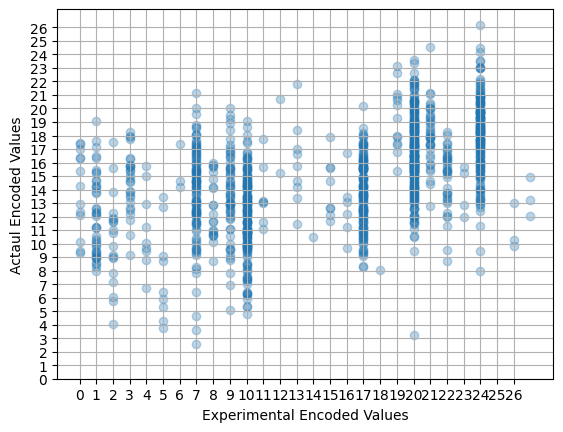

In [91]:
plt.scatter(x=y_train, y=y_lr_train_pred, alpha = 0.3)

plt.plot()
plt.ylabel('Actaul Encoded Values')
plt.xlabel('Experimental Encoded Values')
#how to make the x and y axis display a tick mark for each 1 value
plt.yticks(range(0, 27))
plt.xticks(range(0, 27))
plt.grid()

### Random Forest Regressor

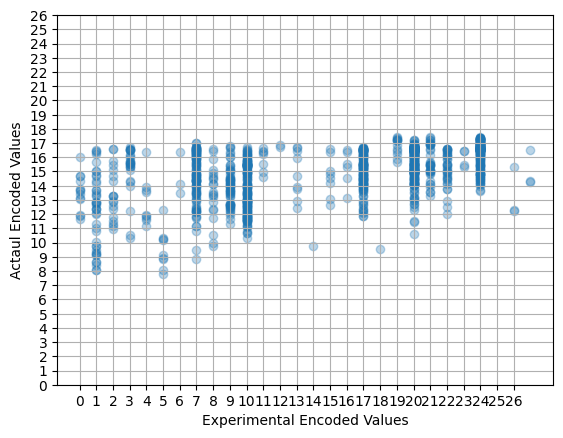

In [92]:
plt.scatter(x=y_train, y=y_rf_train_pred, alpha = 0.3)

plt.plot()
plt.ylabel('Actaul Encoded Values')
plt.xlabel('Experimental Encoded Values')
#how to make the x and y axis display a tick mark for each 1 value
plt.yticks(range(0, 27))
plt.xticks(range(0, 27))
plt.grid()

### Random Forest Classifier

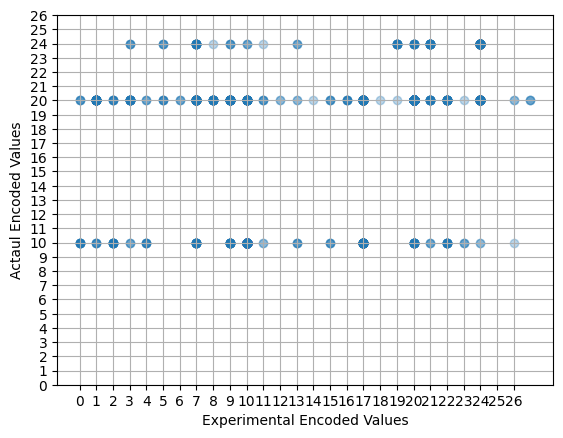

In [93]:
plt.scatter(x=y_train, y=y_rfc_train_pred, alpha = 0.3)

plt.plot()
plt.ylabel('Actaul Encoded Values')
plt.xlabel('Experimental Encoded Values')
#how to make the x and y axis display a tick mark for each 1 value
plt.yticks(range(0, 27))
plt.xticks(range(0, 27))
plt.grid()

## Re-Planning / Project Re-evaluation after the Project go-round 1

### 1. Why are the current models not accurate?
#### The output column is a categorical value. Sheds light on other models that are more stuitable for categorical outputs.

### 2. What are other models that are great to fit categorical output?

###### According to chatgpt the top models are: Logistic Regression, Decision Trees(Classifier), Random Forest (Classifier), Gradient Boosting Machines(GBM), Support Vector Machines (SVM), K-Nearest Neighbors(k-NN), Naive Bayes, and Neural Networks.

###### Here are other models that work with categorical outputs:
###### K-Nearest Neighbors, Support Vector Machine, Decision Trees, Gradient Boosting, AdaBoost, XGBoost, LightGBM, CatBoost, Neural Networks, Logistic Regression, Naive Bayes, Random Forest Classifier, Extra Trees Classifier, Bagging Classifier, Stacking Classifier, Voting Classifier, Gaussian Process Classifier, Quadratic Discriminant Analysis, Linear Discriminant Analysis, Ridge Classifier, Perceptron, Passive Aggressive Classifier, SGD Classifier, Nearest Centroid 

Tasks after Project go-round 1:

- This dataset(high-popularity spotify -> hs_required) has an unbalanced number of genres. This can be easily explained as the majority of spotify users listen to Pop and this dataset is linked to high-popularity of songs with audio features and what genre they belong to. My hypothesis is that the dataset that focuses on non popular songs will have a more balanced dataset ( that will need to be a part 2 to this project). In short, I will need to revisit the data preparation section to balance the data.

Lessons Learned in Project go-round 1:
- The difference between categorical and numerical data
    - Models that run well with categorical data
- Unbalanced data
    - Undersampling, oversampling, up/down weighting
- Metrics for modeling
- Outside influences to skew data
    - i.e. popularity with pop genre
- Creating a robust hypothesis




## Project go-round 2

Focusing on models that perform effectively with categorical output data.

### Data Preparation

In [131]:
# I want an equal number of songs in the other genres to be as much as the pop genre.

m = len(hs_new)

m

1408

In [132]:
hs_testing_bootstrap = hs_new

In [133]:
def boostrap_sample(hs_new, n_samples = 1):
    samples = []
    n = len(hs_new)
    for _ in range(1000):
        sample_indices = np.random.choice(hs_new.index, size=n, replace=True)
        sample = hs_new.loc[sample_indices]
        samples.append(sample)
    return samples

# Generate bootstrap samples
bootstrap_samples = boostrap_sample(hs_new, 1000)

for i, sample in enumerate(bootstrap_samples):
    print(f"Bootstrap Sample {i+1}:\n{sample}\n")

bootstrap_samples_df = pd.concat(bootstrap_samples, ignore_index=True)

Bootstrap Sample 1:
      energy    tempo  danceability  playlist_genre  loudness  liveness  \
823    0.448   95.050         0.599              20    -6.312    0.1060   
1627   0.413  146.050         0.747              10   -11.197    0.1700   
163    0.500   63.925         0.427              10    -8.269    0.1270   
505    0.632  121.031         0.762               9    -8.312    0.1800   
1218   0.476  139.987         0.840               3    -7.918    0.0865   
...      ...      ...           ...             ...       ...       ...   
1510   0.119   70.499         0.467               1   -10.990    0.0973   
394    0.939  129.024         0.671               7    -3.206    0.2980   
1249   0.864   99.995         0.637               8    -4.381    0.2220   
1100   0.796  105.991         0.600              24    -4.481    0.4840   
38     0.454  159.982         0.689              20    -7.643    0.0707   

      valence  time_signature  speechiness  track_popularity  \
823     0.168  

In [134]:

df_combined = pd.concat([hs_testing_bootstrap, bootstrap_samples_df], ignore_index = True)
print(df_combined) 
df_combined['playlist_genre'].value_counts()

         energy    tempo  danceability  playlist_genre  loudness  liveness  \
0         0.592  157.969         0.521              20    -7.777     0.122   
1         0.507  104.978         0.747              20   -10.171     0.117   
2         0.808  108.548         0.554              20    -4.169     0.159   
3         0.910  112.966         0.670              20    -4.070     0.304   
4         0.783  149.027         0.777              20    -4.477     0.355   
...         ...      ...           ...             ...       ...       ...   
1409403   0.866  109.825         0.308              19    -5.671     0.232   
1409404   0.283   97.040         0.766              10   -10.330     0.115   
1409405   0.662  150.047         0.709              10    -4.550     0.108   
1409406   0.725  105.016         0.711              17    -8.315     0.110   
1409407   0.609   95.986         0.652              22    -7.519     0.233   

         valence  time_signature  speechiness  track_popularity

playlist_genre
20    287116
24    203349
10    200819
17    162449
7     124852
9      74041
22     49630
1      49498
21     45883
3      36988
8      28197
2      27177
19     18213
0      15010
4      12892
15     11141
13     11009
5      10023
11      9045
26      6995
16      6974
27      4070
23      3999
6       3056
12      3012
18      1985
25       994
14       991
Name: count, dtype: int64

In [135]:
genre_sample = pd.DataFrame()
sampling_boot_combined = pd.DataFrame()

def sampling_boot(df_combined, encoded_values, n_samples=516):
    samples = []
    for i in encoded_values['Encoded Value']:
        genre_sample = df_combined[df_combined['playlist_genre'] == i]
        if len(genre_sample) >= n_samples:
            genre_sample = genre_sample.sample(n_samples)
        else:
            genre_sample = genre_sample.sample(n_samples, replace=True)
        samples.append(genre_sample)
        # You can add more processing here if needed
    return pd.concat(samples, ignore_index=True)

sampling_boot_combined = sampling_boot(df_combined, encoded_values)
print(sampling_boot_combined)


       energy    tempo  danceability  playlist_genre  loudness  liveness  \
0       0.634  101.837         0.502               0    -3.367    0.1880   
1       0.683  145.379         0.501               0    -7.881    0.0685   
2       0.651   67.813         0.490               0    -6.259    0.1080   
3       0.814   93.482         0.683               0    -3.505    0.0858   
4       0.634  101.837         0.502               0    -3.367    0.1880   
...       ...      ...           ...             ...       ...       ...   
14443   0.321  110.827         0.680              27   -10.944    0.1250   
14444   0.645   85.046         0.714              27    -5.493    0.0942   
14445   0.645   85.046         0.714              27    -5.493    0.0942   
14446   0.588   79.989         0.675              27    -7.168    0.9500   
14447   0.588   79.989         0.675              27    -7.168    0.9500   

       valence  time_signature  speechiness  track_popularity  \
0        0.645        

genre_sample = pd.DataFrame()
sampling_boot_combined = pd.DataFrame()

def sampling_boot(df_combined, encoded_values):
    samples = []
    for i in encoded_values:
        genre_sample = df_combined[df_combined['playlist_genre'] == i]
        genre_sample = genre_sample.sample(516)
        samples.append(genre_sample)
        # You can add more processing here if needed
    return pd.concat(samples, ignore_index=True)

sampling_boot_combined = sampling_boot(df_combined, encoded_values)
print(sampling_boot_combined)


genre_sample = pd.DataFrame()
sampling_boot_combined = pd.DataFrame()

def sampling_boot(df_combined, encoded_values):
    samples = []
    for i in encoded_values:
        genre_sample = df_combined[df_combined['playlist_genre'] == i]
        genre_sample = genre_sample.sample(516)
        samples.append(genre_sample)
        # You can add more processing here if needed
    return pd.concat(samples, ignore_index=True)

sampling_boot_combined = sampling_boot(df_combined, encoded_values)
print(sampling_boot_combined)


Encoded Value Actual Value
0               0    afrobeats
1               1      ambient
2               2       arabic
3               3        blues
4               4    brazilian
5               5    classical
6               6      country
7               7   electronic
8               8         folk
9               9       gaming
10             10      hip-hop
11             11       indian
12             12        indie
13             13        j-pop
14             14         jazz
15             15        k-pop
16             16       korean
17             17        latin
18             18         lofi
19             19        metal
20             20          pop
21             21         punk
22             22          r&b
23             23       reggae
24             24         rock
25             25         soul
26             26      turkish
27             27        world

In [136]:
b = sampling_boot_combined['playlist_genre']
A = sampling_boot_combined.drop('playlist_genre', axis=1)

In [137]:
from sklearn.model_selection import train_test_split

A_train, A_test, b_train, b_test = train_test_split(A,b,test_size=0.2, random_state=42)

### K-Nearst Neighbors

#### KNN Building 

In [138]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(A_train, b_train)
knn.predict(A_test)

knn_accuracy = accuracy_score(b_test, knn.predict(A_test))
print(knn_accuracy)



0.9231833910034603


c:\Users\tbear\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\plotting\decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


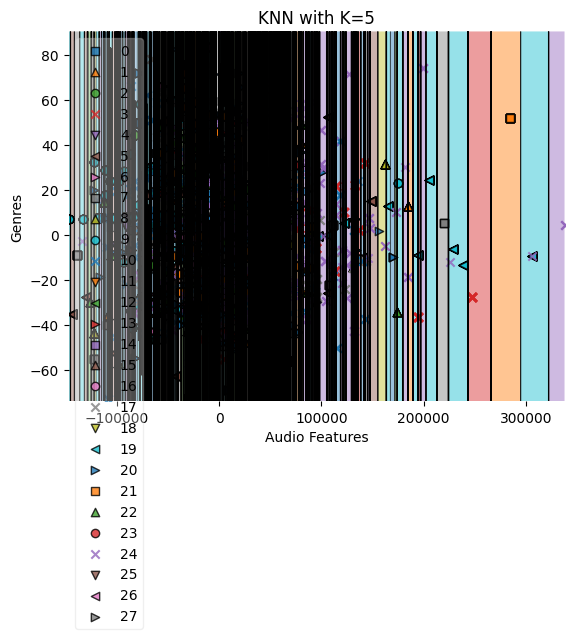

In [139]:
# Import necessary libraries
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions 
from sklearn.decomposition import PCA

#Convert DataFrame to NumPy arrays
A_np = A.values
b_np = b.values

# Reduce the dimensionality of A_np to 2D using PCA
pca = PCA(n_components = 2)
A_pca = pca.fit_transform(A_np)

# Train the KNN model on the reduced 2D data
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(A_pca, b_np)

# Visualize the decision regions of the trained KNN model
plot_decision_regions(A_pca, b_np, clf=knn, legend=2)  

# Label the axes and add a title to the plot
plt.xlabel('Audio Features')  
plt.ylabel('Genres')
plt.title('KNN with K=5')

# Save the plot as an image file with tight bounding box and high resolution (150 dpi)
#plt.savefig('KNN with K=5.jpeg', bbox_inches="tight", dpi=150)

# Step 8: Display the plot
plt.show()

In [140]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline(
    steps=[("scaler",StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors = 11))]
)

import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

_, axs = plt.subplots(ncols=2, figsize=(12,5))

for ax, weights in zip(axs, ("uniform","distance")):
    clf.set_params(knn__weights=weights).fit(A_train, b_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        A_test,
        response_method = "predict",
        plot_method="pcolormesh",
        xlabel="audio features",
        ylabel = "encoded genre values",
        shading = "auto",
        alpha = 0.5,
        ax=ax,
    )
scatter=disp.ax_scatter(A.iloc[:,0],A.iloc[:,1], c=b, edgecolors="k")
disp.ax_legend(
    scatter.legend_elements()[0],
    b['playlist_genre'],
    loc = "lower left",
    title = "Genres",
)
_ = disp.ax_.set_title(
    f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
)
plt.show
# I want to comment out this whole kernal


### Logistic Regression

In [141]:
from sklearn.linear_model import LogisticRegression

#A_LogR = pd.get_dummies(A, predix='', prefix_sep='', drop_first=True)

logit_reg = LogisticRegression(penalty= 'l2', C=1e42, solver='liblinear')
logit_reg.fit(A_train,b_train)

LogisticRegression(C=1e+42, solver='liblinear')

In [142]:
b_pred_logreg = logit_reg.predict(A_test)

accuracy_log_reg=accuracy_score(b_test, b_pred_logreg)
print("Logistic Regression Accuracy:", accuracy_log_reg)

Logistic Regression Accuracy: 0.18200692041522493


### Naive Bayes ( Multinomial )

In [143]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB

# Scale the data to be between 0 and 1
scaler = MinMaxScaler()
A_train_scaled = scaler.fit_transform(A_train)
A_test_scaled = scaler.transform(A_test)

multinomialNB_model = MultinomialNB(alpha=0.01, fit_prior=True)
multinomialNB_model.fit(A_train_scaled, b_train)

MultinomialNB(alpha=0.01)

In [144]:
b_pred_multinomialNB = multinomialNB_model.predict(A_test_scaled)

accuracy_multinomialNB = accuracy_score(b_test, b_pred_multinomialNB)
print("Naive Bayes Accuracy: ", accuracy_multinomialNB)

Naive Bayes Accuracy:  0.3505190311418685


### Naive Bayes ( Gaussian )

In [145]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB

gaussianNB_model = GaussianNB()
gaussianNB_model.fit(A_train_scaled, b_train)

GaussianNB()

In [146]:
b_pred_gaussianNB = gaussianNB_model.predict(A_test_scaled)
accuracy_gaussianNB = accuracy_score(b_test, b_pred_gaussianNB)
print("Gaussian Accuracy Score:", accuracy_gaussianNB)

Gaussian Accuracy Score: 0.5179930795847751


### Random Forest Classifier (part 2)

In [147]:
from sklearn.ensemble import RandomForestClassifier

In [148]:
rfc = RandomForestClassifier(max_depth=2, random_state=100)
rfc.fit(A_train, b_train)

RandomForestClassifier(max_depth=2, random_state=100)

In [149]:
b_rfc_train_pred = rfc.predict(A_train)
b_rfc_test_pred = rfc.predict(A_test)

In [150]:
accuracy_rfclass = accuracy_score(b_test, b_rfc_test_pred)
print("Accuracy Score for RF Classifier:", accuracy_rfclass)

Accuracy Score for RF Classifier: 0.3674740484429066


### Random Forest Regressor (part 2)

In [151]:
from sklearn.ensemble import RandomForestRegressor

In [152]:
rfReg = RandomForestRegressor(max_depth=2, random_state=100)
rfReg.fit(A_train, b_train)

RandomForestRegressor(max_depth=2, random_state=100)

In [153]:
b_rfReg_train_pred = rfReg.predict(A_train)
b_rfReg_test_pred = rfReg.predict(A_test)

In [154]:
from sklearn.metrics import mean_squared_error, r2_score

rfReg_test_mse = mean_squared_error(b_test, b_rfReg_test_pred)
rfReg_test_r2 = r2_score(b_test, b_rfReg_test_pred)

print(f"Test MSE: {rfReg_test_mse}, Test R2: {rfReg_test_r2}")

Test MSE: 55.48202028418121, Test R2: 0.13488997049990892


In [157]:
# Symbolic regression is a type of regression analysis that searches for mathematical expressions that best fit a given dataset

from gplearn.genetic import SymbolicRegressor

#Create the Symbolic Regressor
py_SR = SymbolicRegressor(population_size = 5000, generations=100, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=42)

#Fit the model
py_SR.fit(A_train, b_train)

#Predict on the test set
b_pred_pySR = py_SR.predict(A_test)

#Calcular the mean squared error
mse_pySR = mean_squared_error(b_test, b_pred_pySR)
print(f"Mean Squared Error: {mse_pySR}" )

#Print the best found formula
print(f"Best formula: {py_SR._program}")

c:\Users\tbear\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    26.28      2.99744e+27        5          7.33026          7.10179      9.07m
   1     6.96      6.45774e+09        9          7.22654          7.18181      6.21m
   2     8.23      2.63419e+06       11          7.02789          7.13531      6.28m
   3     7.20      4.21935e+07       15          6.97401          6.90743      5.97m
   4     8.20      1.24175e+08       17          6.92906          7.14573      6.52m
   5     9.27      8.01747e+08       19          6.91848          7.22746      7.09m
   6     9.20      2.34703e+09       13          6.88969          7.18318      7.48m
   7     8.89      2.20729e+07       21          6.89669          7.31119      6.62m
   8     8.86      9.27316e+11       13          6.84836          6.90911  

KeyboardInterrupt: 